loading annotations into memory...
Done (t=0.69s)
creating index...
index created!
path: /home/delong/workspace/dataset/coco2017/images/val2017/000000132622.jpg
segment: torch.Size([508, 559, 3]), mask: (508, 559), label: 23


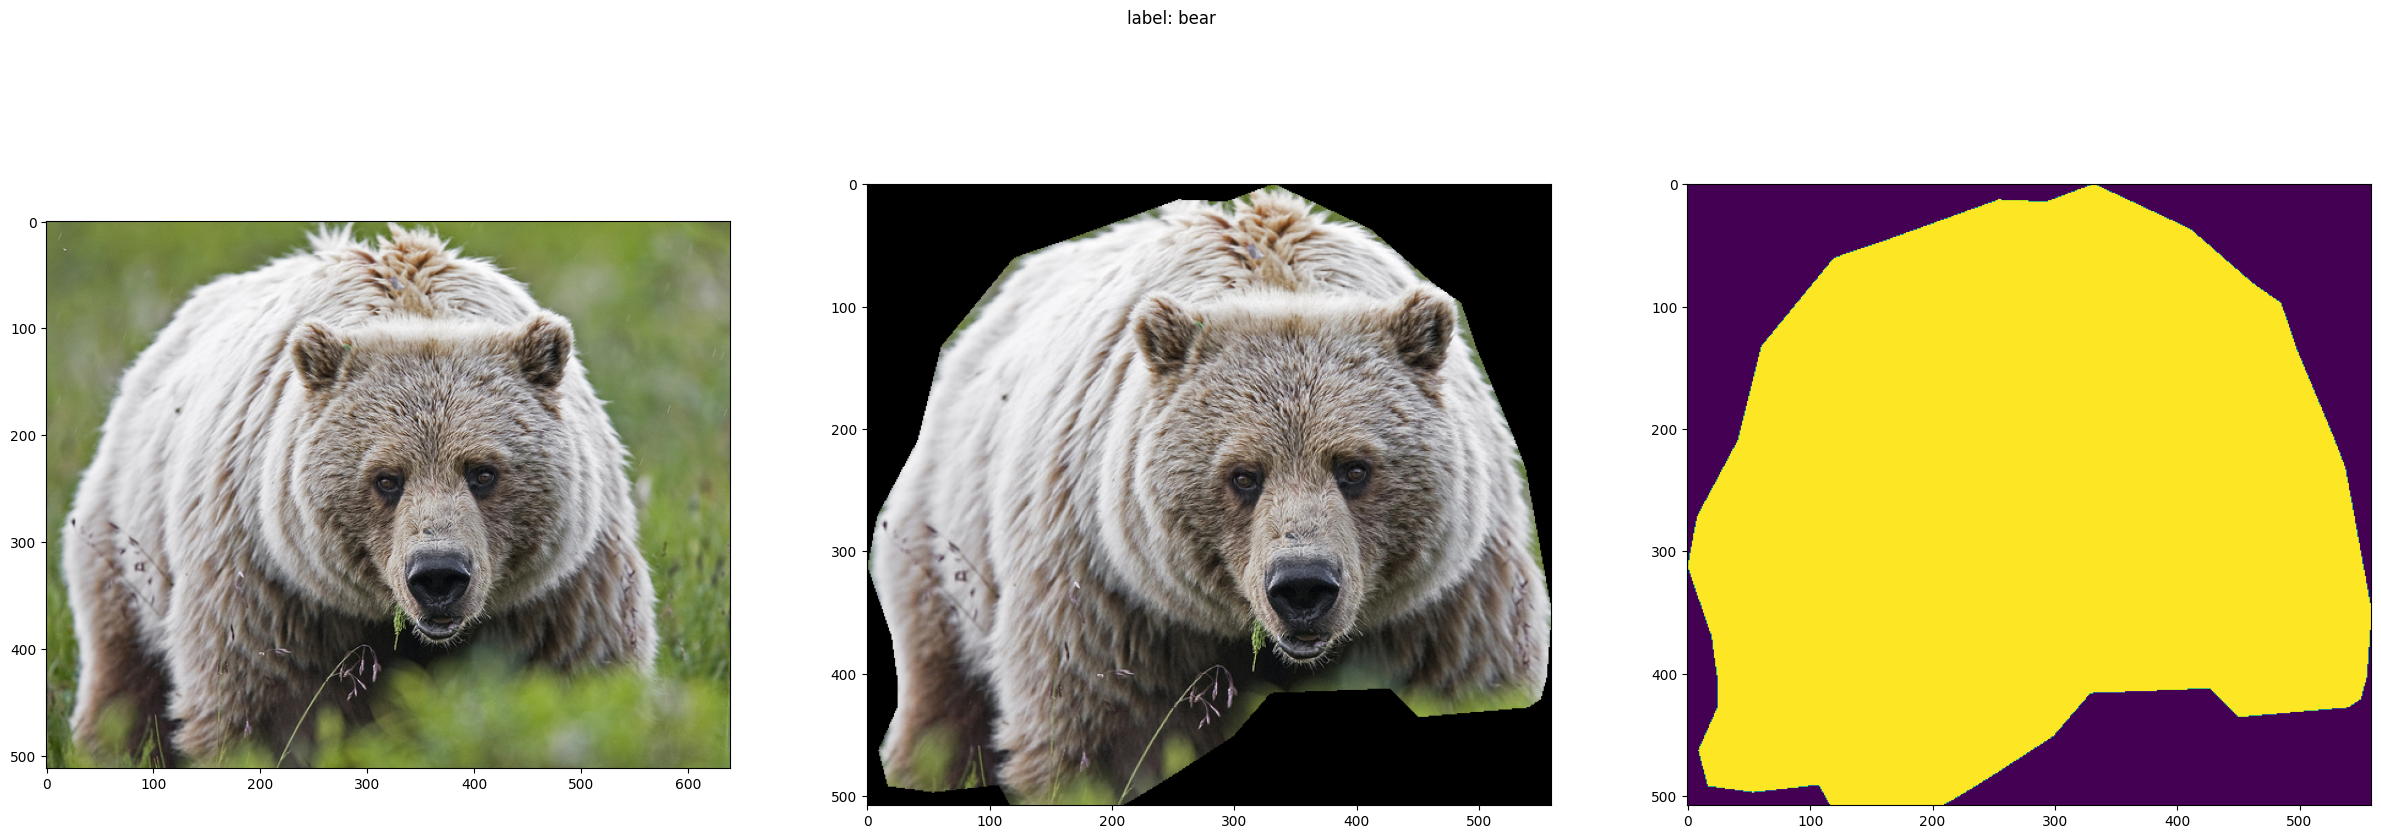

In [3]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO

class COCOMaskDataset(Dataset):
    def __init__(self, coco_root, split='train', virtual_dataset_size=1000):
        self.coco_root = coco_root
        if split == 'train':
            self.sub_dir = 'train2017'
        elif split == 'val':
            self.sub_dir = 'val2017'
        else:
            raise NotImplementedError

        self.coco = COCO(f'{self.coco_root}/annotations/instances_{self.sub_dir}.json')
        self.img_ids = list(sorted(self.coco.imgs.keys()))
        self.virtual_dataset_size = virtual_dataset_size
        self.id_to_name = {category['id']: category['name'] for category in self.coco.loadCats(self.coco.getCatIds())}

        self.sample_buffer = []

    def load_image(self, image_index=None):
        if image_index is None:
            image_index = np.random.randint(0, len(self.img_ids))

        img_id = self.img_ids[image_index]
        img_path = f"{self.coco_root}/images/{self.sub_dir}/{self.coco.loadImgs(img_id)[0]['file_name']}"
        img = Image.open(img_path)
        img = torch.from_numpy(np.array(img))

        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        annotations = self.coco.loadAnns(ann_ids)

        labels = [annotation['category_id'] for annotation in annotations]
        masks = [self.coco.annToMask(annotation) for annotation in annotations]
        bboxs = [[int(b) for b in annotation['bbox']] for annotation in annotations]

        samples = self.prepare_samples(img_path, img, masks, bboxs, labels)
        self.sample_buffer = samples
            
    def prepare_samples(self, img_path, img, masks, bboxs, labels):
        samples = []
        for mask, bbox, label in zip(masks, bboxs, labels):
            masked_img = img * mask[:, :, None]

            x, y, w, h = bbox
            cropped_img = masked_img[y:y+h, x:x+w]
            cropped_mask = mask[y:y+h, x:x+w]

            samples.append({
                "path": img_path,
                "segment": cropped_img,
                "mask": cropped_mask,
                "label": label,
            })
        return samples

    
    def segment_to_sequence(self, segment, mask):
        


    def __getitem__(self, index):
        if len(self.sample_buffer) == 0:
            self.load_image()

        sample = self.sample_buffer.pop()
        return sample

    def __len__(self):
        return self.virtual_dataset_size

# Create the dataset
coco_root = '/home/delong/workspace/dataset/coco2017'
split = 'val'
dataset = COCOMaskDataset(coco_root, split)

for i in range(1):
    sample = dataset[i]
    print(f"path: {sample['path']}")
    print(f"segment: {sample['segment'].shape}, mask: {sample['mask'].shape}, label: {sample['label']}")

    # visualize image, segment and mask
    fig, axes = plt.subplots(1, 3, figsize=(30, 10))
    axes[0].imshow(Image.open(sample['path']))
    axes[1].imshow(sample['segment'] * sample['mask'][:, :, None])
    axes[2].imshow(sample['mask'])
    plt.suptitle(f"label: {dataset.id_to_name[sample['label']]}")
    plt.show()
